In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re

In [0]:
# tf.enable_eager_execution()


In [0]:
import zipfile as z

In [0]:
from google.colab import drive
MOUNT_POINT_DRIVE = '/content/gdrive'
drive.mount(MOUNT_POINT_DRIVE)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
PATH_TO_DATA = '/content/gdrive/My Drive/Colab Notebooks/'

In [0]:
train, test = z.ZipFile(PATH_TO_DATA + 'train.csv.zip').extract('train.csv'), z.ZipFile(PATH_TO_DATA + 'test.csv.zip').extract('test.csv')

In [0]:
train, test = pd.read_csv(train), pd.read_csv(test)

In [0]:
corpus, target = train['text'], train['labels']

In [0]:
if -1 in target.unique():
  sub = target.unique().shape[0]
  target = target.transform(lambda x:x + sub if x==-1 else x)

In [0]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
def transform(corpus):
  pattern = re.compile(r'[^A-Za-z ]')  
  corpus = corpus.apply(lambda x: x.lower())
  corpus = corpus.apply(lambda x: re.sub(pattern, ' ', x))
  
  corpus = corpus.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))
  
  lemmatizer = nltk.WordNetLemmatizer()
  corpus = corpus.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
  
  return corpus

In [0]:
corpus = transform(corpus)

In [0]:
d = {}
for line in corpus:
  for word in line.split():
    if word not in d:
      d[word]=1
    else:
      d[word]+=1

In [0]:
pad_index=0
start_index=1
out_index=2
shuffle_index=1

def index_corpus(corpus):
  corpus_embeded = []

  for line in corpus:
    line_embeded = [1]
    for word in line.split():
      line_embeded.append(d[word]+shuffle_index if word in d and d[word]>1  else 2)
    corpus_embeded.append(line_embeded)
  return corpus_embeded

corpus_embeded = index_corpus(corpus)

In [0]:
lens = []

for line in corpus_embeded:
  lens.append(len(line))

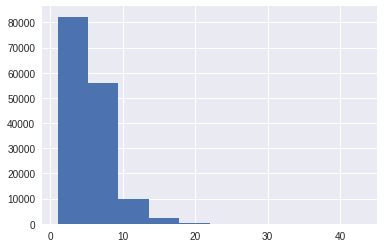

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(lens);

In [0]:
sentence_size = 15

from keras.preprocessing.sequence import pad_sequences

corpus_embeded = pad_sequences(corpus_embeded, maxlen = sentence_size, padding='post', truncating='post')

Using TensorFlow backend.


In [0]:
corpus_embeded.shape

(150832, 15)

In [0]:
corpus_embeded[:5]

array([[   1,   74,   17,  236,   42,  248,   42,   15,  713,    0,    0,
           0,    0,    0,    0],
       [   1,   48,   17,  236,  248,    8,   17,  713,    0,    0,    0,
           0,    0,    0,    0],
       [   1, 4572,    4,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   1,  525,    4,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   1,  804, 1802,  507,  145,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int32)

In [0]:
target[:5]

0    0
1    0
2    1
3    1
4    2
Name: labels, dtype: int64

Сейчас буду писать функцию для импута в трейне

In [0]:
def my_input_fn(x_train, labels, params, training=False):
  data = tf.data.Dataset.from_tensor_slices(({
            'sentences': x_train}
                                             
            , labels))
  
  if training:
    data = data.shuffle(buffer_size=params['buffer_size'])
    data = data.repeat(params['num_of_epochs'])
    
  data = data.batch(params['batch_size'], drop_remainder=True)
  iterator = data.make_one_shot_iterator()
  batch_feat, batch_lab = iterator.get_next()
  
  return batch_feat, batch_lab

Здесь пишу функцию для модели

In [0]:
def my_model_fn(features, labels, mode, params):
  input_layer = tf.contrib.layers.embed_sequence(features['sentences'],
                                                 vocab_size= params['vocab_size'],
                                                 embed_dim = params['embed_size'],
                                                 initializer = params['embed_init'])
  
  rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(64)
  
  _, final_state = tf.nn.dynamic_rnn(rnn_cell, input_layer, sequence_length=[sentence_size]*params['batch_size'], dtype=tf.float32)
  
  logits = tf.layers.dense(final_state.h, units=params['num_of_classes'])
  
  predictions = {'class_id':tf.argmax(logits, axis=1)}
  
  if mode==tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(
            mode,
            predictions=predictions
    )
  
  
  loss = tf.losses.sparse_softmax_cross_entropy(labels, logits)
  
  accuracy = tf.metrics.accuracy(labels, predictions['class_id'])

  
  if mode==tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss, global_step = tf.train.get_global_step())
    
    return tf.estimator.EstimatorSpec(
             mode,
             loss = loss,
             train_op = train_op
    )
  
  
  if mode==tf.estimator.ModeKeys.EVAL:
    return tf.estimator.EstimatorSpec(
        mode,
        loss = loss,
        eval_metric_ops = {'accuracy': accuracy}
    )

Сделать классификатор

In [0]:
def set_new_session():
  sess = tf.get_default_session()
  if sess is not None:
    sess.close()
  tf.reset_default_graph()
  config = tf.ConfigProto()
  s = tf.InteractiveSession(config=config)
  return s

s = set_new_session()

In [0]:
x_train, y_train = corpus_embeded, target

In [0]:
assert x_train.shape[0]==y_train.shape[0]

In [0]:
import operator
def get_vocab_size(d, threshold):
  sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
  d = dict(sorted_d)
  for elem, index in zip(d.items(), range(len(d))):
    if elem[1]==threshold:
      vocab_size = index
      break
  return vocab_size

threshold = 1
vocab_size = get_vocab_size(d, threshold)
print('vocab_size: ', vocab_size)
embed_size=50
embed_init = tf.random_normal_initializer()
num_of_classes = y_train.unique().shape[0]
batch_size=100

vocab_size:  21294


In [0]:
params = {'vocab_size':vocab_size, 'embed_size':embed_size, 'embed_init': embed_init, 'num_of_classes': num_of_classes, 'batch_size':batch_size}

In [0]:
classifier  = tf.estimator.Estimator(model_fn = my_model_fn, model_dir = '/content/gdrive/My Drive/Colab Notebooks/60k text classification', params = params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/Colab Notebooks/60k text classification', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efffa59b438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Train

In [0]:
params_for_input = {'buffer_size':x_train.shape[0], 'num_of_epochs':5, 'batch_size':batch_size}
classifier.train(input_fn = lambda: my_input_fn(x_train, y_train, params_for_input, training=True))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/60k text classification/model.ckpt-9199
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9199 into /content/gdrive/My Drive/Colab Notebooks/60k text classification/model.ckpt.
INFO:tensorflow:loss = 9.2030325, step = 9199
INFO:tensorflow:global_step/sec: 36.7479
INFO:tensorflow:loss = 8.163788, step = 9299 (2.728 sec)
INFO:tensorflow:global_step/sec: 40.461
INFO:tensorflow:loss = 8.236622, step = 9399 (2.474 sec)
INFO:tensorflow:global_step/sec: 40.3657
INFO:tensorflow:loss = 8.121407, step = 9499 (2.474 sec)
INFO:tensorflow:global_step/sec: 39.896
INFO:tensorflow:loss = 7.7486706, step = 9599 (2.508 sec)
INFO:tensorflow:global_step/sec: 37.1587
INFO:tensorflow:loss = 8.609973, ste

Eval

In [0]:
params_for_input_eval = {'buffer_size':x_train.shape[0], 'num_of_epochs':1, 'batch_size':batch_size}
eval_res = classifier.evaluate(input_fn = lambda: my_input_fn(x_train, y_train, params_for_input_eval, training=False))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-21T17:55:25Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/60k text classification/model.ckpt-16740
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-21-17:56:01
INFO:tensorflow:Saving dict for global step 16740: accuracy = 0.1991313, global_step = 16740, loss = 6.67159
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 16740: /content/gdrive/My Drive/Colab Notebooks/60k text classification/model.ckpt-16740


Predict

In [0]:
test_corpus = test['text']
test_corpus = transform(test_corpus)

test_corpus_embeded = index_corpus(test_corpus)

test_corpus_embeded = pad_sequences(test_corpus_embeded, maxlen = sentence_size, padding='post', truncating='post')

In [0]:
test_corpus_embeded.shape

(58788, 15)

In [0]:
def predict_input_fn(x_test):
  data = tf.data.Dataset.from_tensor_slices(({
            'sentences': x_test}))
    
  data = data.repeat(1)
  data = data.batch(batch_size)
  iterator = data.make_one_shot_iterator()
  batch = iterator.get_next()
  return batch

In [0]:
test_swallen = np.concatenate((test_corpus_embeded, np.zeros(shape=(12, 15), dtype=np.int32)))

In [0]:
test_swallen.shape

(58800, 15)

In [0]:
predictions = classifier.predict(input_fn = lambda: predict_input_fn(test_swallen))

In [0]:
results = []

for elem in predictions:
  results.append(elem['class_id'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/60k text classification/model.ckpt-16740
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [0]:
results = results[:-12]

In [0]:
assert len(results)==test_corpus_embeded.shape[0]

In [0]:
! touch '/content/submision.csv'

In [0]:
with open('/content/submision.csv', 'w') as file:
  file.write('index' +',' + 'labels' + '\n')
  for index, label in zip(range(len(results)), results):
    file.write(str(index) + ',' + str(label) + '\n' if label!= 60416 else str(index) + ',' + str(-1) + '\n')

In [0]:
! KAGGLE_USERNAME='nikitamartynov' KAGGLE_KEY='3fabe7b3f96f3f0b04b23fd757efb93c' kaggle competitions submit -c 60k-classes-text-classification -f submision.csv -m "pls, do not judge"

100% 506k/506k [00:11<00:00, 46.2kB/s]
Successfully submitted to 60k Classes Text Classification

Сделать на нормальных эмбедингах

In [0]:
! mkdir '/content/gdrive/My Drive/Embeddings'

mkdir: cannot create directory ‘/content/gdrive/My Drive/Embeddings’: File exists


In [0]:
! wget -P '/content/gdrive/My Drive/Embeddings' 'http://nlp.stanford.edu/data/glove.6B.zip'

--2019-03-22 09:57:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-03-22 09:57:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/gdrive/My Drive/Embeddings/glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.43MB/s    in 2m 18s  

2019-03-22 09:59:25 (5.96 MB/s) - ‘/content/gdrive/My Drive/Embeddings/glove.6B.zip’ saved [862182613/862182613]



In [0]:
embeddings_size = 300

EMBEDDINGS_FILE = 'glove.6B.' + str(embeddings_size) + 'd.txt'

embeddings = z.ZipFile('/content/gdrive/My Drive/Embeddings/glove.6B.zip').extract(EMBEDDINGS_FILE)

In [0]:
e = {}
with open(embeddings) as file:
  for line in file:
    s = line.split()
    word = s[0]
    vector = np.asarray(list(map(np.float, s[1:])), dtype=np.float32)
    
    assert vector.shape[0]==embeddings_size
    
    e[word] = vector

Перекодирую предложения

In [0]:
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
d_s = dict(sorted_d)

In [0]:
for elem, index in zip(d_s.items(), range(len(d_s))):
  d_s[elem[0]] = index + 3

In [0]:
def reindex_corpus(corpus):
  corpus_embeded = []
  
  for line in corpus:
    line_embeded = [1]
    for word in line.split():
      line_embeded.append(d_s[word] if word in d_s else out_index)
    corpus_embeded.append(line_embeded)
    
  return corpus_embeded


corpus_reembeded = reindex_corpus(corpus)
  
corpus_reembeded = pad_sequences(corpus_reembeded, maxlen = sentence_size, padding='post', truncating='post')

Сделаю матрицу новых эмбедингов

In [0]:
vocab_size = get_vocab_size(d, threshold)

embeddings_matrix = np.random.normal(size=(vocab_size + 3, embeddings_size))

for word, index in d_s.items():
  if index <=vocab_size and word in e:
    embeddings_matrix[index] = e[word]
    
embeddings_matrix = np.asarray(embeddings_matrix, dtype=np.float32)

In [0]:
assert embeddings_matrix.shape == (vocab_size + 3, embeddings_size)

Инициализатор

In [0]:
def my_initializer(shape=None, dtype=tf.float32, partition_info=None):
    assert dtype is tf.float32
    return embeddings_matrix

Модель та же

In [0]:
x_train, y_train = corpus_reembeded, target

In [0]:
num_of_classes = y_train.unique().shape[0]
batch_size=100

In [0]:
params = {'vocab_size':vocab_size, 'embed_size':embeddings_size, 'embed_init': my_initializer, 'num_of_classes': num_of_classes, 'batch_size':batch_size}

In [0]:
classifier_pretrained  = tf.estimator.Estimator(model_fn = my_model_fn, model_dir = '/content/gdrive/My Drive/Colab Notebooks/60k text classification/pretrained_', params = params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/Colab Notebooks/60k text classification/pretrained_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8df8fda5f8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Train

In [0]:
s = set_new_session()

In [0]:
params_for_input = {'buffer_size':x_train.shape[0], 'num_of_epochs':1, 'batch_size':batch_size}
classifier_pretrained.train(input_fn = lambda: my_input_fn(x_train, y_train, params_for_input, training=True))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/60k text classification/pretrained_/model.ckpt-9049
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9049 into /content/gdrive/My Drive/Colab Notebooks/60k text classification/pretrained_/model.ckpt.
INFO:tensorflow:loss = 8.712929, step = 9049
INFO:tensorflow:global_step/sec: 34.9171
INFO:tensorflow:loss = 9.092016, step = 9149 (2.866 sec)
INFO:tensorflow:global_step/sec: 39.153
INFO:tensorflow:loss = 9.527919, step = 9249 (2.554 sec)
INFO:tensorflow:global_step/sec: 38.7836
INFO:tensorflow:loss = 9.663826, step = 9349 (2.583 sec)
INFO:tensorflow:global_step/sec: 30.5234
INFO:tensorflow:loss = 9.610166, step = 9449 (3.276 sec)
INFO:tensorflow:global_step/sec: 38.7937
INFO:tensorfl

Evaluate

In [0]:
params_for_input_eval = {'buffer_size':x_train.shape[0], 'num_of_epochs':1, 'batch_size':batch_size}
eval_res = classifier_pretrained.evaluate(input_fn = lambda: my_input_fn(x_train, y_train, params_for_input_eval, training=False))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-24T16:17:44Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/60k text classification/pretrained_/model.ckpt-9049
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-24-16:18:21
INFO:tensorflow:Saving dict for global step 9049: accuracy = 0.19995359, global_step = 9049, loss = 9.155079
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9049: /content/gdrive/My Drive/Colab Notebooks/60k text classification/pretrained_/model.ckpt-9049


Predict

In [0]:
test_corpus = test['text']
test_corpus = transform(test_corpus)

test_corpus_embeded = reindex_corpus(test_corpus)

test_corpus_embeded = pad_sequences(test_corpus_embeded, maxlen = sentence_size, padding='post', truncating='post')

In [0]:
test_swallen = np.concatenate((test_corpus_embeded, np.zeros(shape=(12, 15), dtype=np.int32)))

In [0]:
test_swallen.shape

(58800, 15)

In [0]:
predictions = classifier_pretrained.predict(input_fn = lambda: predict_input_fn(test_swallen))

In [0]:
results = []

for elem in predictions:
  results.append(elem['class_id'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/60k text classification/pretrained_/model.ckpt-10557
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [0]:
results = results[:-12]

assert len(results)==test_corpus_embeded.shape[0]

In [0]:
! touch '/content/submission.csv'

In [0]:
with open('/content/submission.csv', 'w') as file:
  file.write('index' +',' + 'labels' + '\n')
  for index, label in zip(range(len(results)), results):
    file.write(str(index) + ',' + str(label) + '\n' if label!= 60416 else str(index) + ',' + str(-1) + '\n')

In [0]:
! KAGGLE_USERNAME='nikitamartynov' KAGGLE_KEY='3fabe7b3f96f3f0b04b23fd757efb93c' kaggle competitions submit -c 60k-classes-text-classification -f submission.csv -m "pls, do not judge"

100% 508k/508k [00:00<00:00, 1.65MB/s]
Successfully submitted to 60k Classes Text Classification

Не сработало

Try convs + rnn

In [0]:
def my_model_fn_cnn(features, labels, mode, params):
  input_layer = tf.contrib.layers.embed_sequence(features['sentences'],
                                                 vocab_size= params['vocab_size'],
                                                 embed_dim = params['embed_size'],
                                                 initializer = params['embed_init'])
  
  conv1 = tf.layers.conv1d(inputs=input_layer,
                      filters=128,
                       kernel_size=5,
                      padding='same',
                      activation=tf.nn.relu)
  
  conv2 = tf.layers.conv1d(inputs=conv1,
                      filters=256,
                       kernel_size=5,
                      padding='same',
                      activation=tf.nn.relu)
  
  conv3 = tf.layers.conv1d(inputs=conv2,
                      filters=256,
                       kernel_size=4,
                      padding='same',
                      activation=tf.nn.relu)
  
  conv4 = tf.layers.conv1d(inputs=conv3,
                      filters=512,
                       kernel_size=4,
                      padding='same',
                      activation=tf.nn.relu)
  
  conv5 = tf.layers.conv1d(inputs=conv4,
                      filters=768,
                       kernel_size=3,
                      padding='same',
                      activation=tf.nn.relu)
  
  conv6 = tf.layers.conv1d(inputs=conv5,
                      filters=1024,
                       kernel_size=3,
                      padding='same',
                      activation=tf.nn.relu)
  
  conv7 = tf.layers.conv1d(inputs=conv6,
                      filters=2048,
                       kernel_size=3,
                      padding='same',
                      activation=tf.nn.relu)
  
  conv8 = tf.layers.conv1d(inputs=conv7,
                      filters=4096,
                       kernel_size=3,
                      padding='same',
                      activation=tf.nn.relu)
  
  rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(64)
  
  _, final_state = tf.nn.dynamic_rnn(rnn_cell, conv8, sequence_length = [sentence_size]*params['batch_size'], dtype=tf.float32)
                             
    
  dense1 = tf.layers.dense(final_state.h, units=1000, activation=tf.nn.relu)
  
  logits = tf.layers.dense(dense1, units=params['num_of_classes'])
  
  predictions = {'class_id':tf.argmax(logits, axis=1)}
  
  if mode==tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(
            mode,
            predictions=predictions
    )
  
  
  loss = tf.losses.sparse_softmax_cross_entropy(labels, logits)
  
  accuracy = tf.metrics.accuracy(labels, predictions['class_id'])

  
  if mode==tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss, global_step = tf.train.get_global_step())
    
    return tf.estimator.EstimatorSpec(
             mode,
             loss = loss,
             train_op = train_op
    )
  
  
  if mode==tf.estimator.ModeKeys.EVAL:
    return tf.estimator.EstimatorSpec(
        mode,
        loss = loss,
        eval_metric_ops = {'accuracy': accuracy}
    )

In [0]:
params = {'vocab_size':vocab_size, 'embed_size':embed_size, 'embed_init': embed_init, 'num_of_classes': num_of_classes, 'batch_size':batch_size}
classifier_cnn = tf.estimator.Estimator(model_fn = my_model_fn_cnn, model_dir = '/content/gdrive/My Drive/Colab Notebooks/60k text classification/cnn_with_rnn', params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/content/gdrive/My Drive/Colab Notebooks/60k text classification/cnn_with_rnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f94d87c7b00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Train cnn

In [0]:
params_for_input = {'buffer_size':x_train.shape[0], 'num_of_epochs':6, 'batch_size':batch_size}
classifier_cnn.train(input_fn = lambda: my_input_fn(x_train, y_train, params_for_input, training=True))

INFO:tensorflow:Calling model_fn.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /content/gdrive/My Drive/Colab Notebooks/60k text classification/cnn_with_rnn/model.ckpt.
INFO:tensorflow:loss = 11.008908, step = 0
INFO:tensorflow:global_step/sec: 3.19218
INFO:tensorflow:loss = 10.015626, step = 100 (31.333 sec)
INFO:tensorflow:global_step/sec: 3.22239
INFO:tensorflow:loss = 10.198894, step = 200 (31.029 sec)
INFO:tensorflow:global_step/sec: 3.22876
INFO:tensorflow:loss = 10.611458, step = 300 (30.974 sec)
INFO:tensorflow:global_step/sec: 3.22762
INFO:tensorflow:loss 

Predict

In [0]:
predictions = classifier_cnn.predict(input_fn = lambda: predict_input_fn(test_swallen))

In [0]:
results = []

for elem in predictions:
  results.append(elem['class_id'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/60k text classification/cnn_with_rnn/model.ckpt-9049
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [0]:
results = results[:-12]

In [0]:
! touch '/content/submission_cnn_rnn.csv'

In [0]:
with open('/content/submission_cnn_rnn.csv', 'w') as file:
  file.write('index' +',' + 'labels' + '\n')
  for index, label in zip(range(len(results)), results):
    file.write(str(index) + ',' + str(label) + '\n' if label!= 60416 else str(index) + ',' + str(-1) + '\n')

In [0]:
! KAGGLE_USERNAME='nikitamartynov' KAGGLE_KEY='3fabe7b3f96f3f0b04b23fd757efb93c' kaggle competitions submit -c 60k-classes-text-classification -f submission_cnn_rnn.csv -m "pls, do not judge"

100% 506k/506k [00:08<00:00, 63.7kB/s]
Successfully submitted to 60k Classes Text Classification